In [332]:
import numpy as np
import matplotlib.pyplot as plt

def compare_renting_vs_buying(buying_price, down_payment_percent, mortgage_rate, appreciation_rate, 
                              discount_rate, time_horizon, monthly_rent, monthly_rent_out, inflation_rate, 
                              investment_rate, property_tax_rate, insurance_rate, rent_out_after_n_years, 
                              yearly_maintenance_cost=0.02, commission=0.03):
    
    # Calculate initial loan balance
    down_payment = buying_price * down_payment_percent
    loan_balance = buying_price - down_payment
    loan_term_years=30 #Assume 30 year fixed.
    n = loan_term_years * 12  # Total number of payments
    r = mortgage_rate / 12  # Monthly interest rate

    # Calculate monthly mortgage payment (principal and interest)
    M = loan_balance * r * (1 + r)**n / ((1 + r)**n - 1)
#     print(f'Monthly payment: {M}')
    
    # Initialize the present value of the equity in the house with the down payment
    pv_equity = down_payment
    
    # Initialize the total present value cost of buying the house with zero
    total_pv_cost_of_buying = 0
    
    # Initialize the total present value of renting and investing the difference with zero
    total_pv_rent_and_invest = 0
    total_savings = 0  #needed for capturing the difference between rent and homeownership costs.
    monthly_investment_rate = (1 + investment_rate)**(1/12) - 1
       
    for t in range(1, time_horizon * 12 + 1):  # Monthly loop
#         print(f'Month:{t}')
        # Mortgage payment calculations
        monthly_interest = loan_balance * r
        monthly_principal = M - monthly_interest
        loan_balance -= monthly_principal
#         print(f'Monthly Principal:{monthly_principal}')
        
        # Other monthly costs of homeownership
        monthly_property_tax = (property_tax_rate / 12) * buying_price 
        monthly_insurance = (insurance_rate / 12) * buying_price
        monthly_maintenance = (yearly_maintenance_cost / 12) * buying_price
        
        # Total monthly cost of homeownership inflation adjusted
        total_monthly_homeownership_cost = M + (monthly_property_tax + monthly_insurance + monthly_maintenance)* (1 + inflation_rate)**(t/12)
#         print(f'total_monthly_homeownership_cost:{total_monthly_homeownership_cost}')

        # Present value of the monthly homeownership (cost)
        total_pv_cost_of_buying += (total_monthly_homeownership_cost-monthly_principal)/ (1 + discount_rate)**(t/12)  # Update total PV cost of buying with interest payment
#         print(f'total_pv_cost_of_buying:{total_pv_cost_of_buying}')    

        # Present value of the monthly principal payment (positive equity)
        pv_monthly_principal = monthly_principal / (1 + discount_rate)**(t/12)
        pv_equity += pv_monthly_principal  # Update the present value of the equity with the principal payment

        # Step 2a: Compound the current savings
        total_savings = total_savings * (1 + monthly_investment_rate)
        
        # Renting calculations
        if t/12 < rent_out_after_n_years:
            rent_for_month_t = monthly_rent * (1 + inflation_rate)**(t/12)
            monthly_savings = total_monthly_homeownership_cost - rent_for_month_t  # Monthly savings from renting
            
            #If renting is cheaper than owning
            if monthly_savings > 0: 
                total_savings += monthly_savings


        # Add rental income if the house is being rented out after certain years
        if t/12 >= rent_out_after_n_years:
            pv_annual_rent_out = monthly_rent_out * (1 + inflation_rate)**(t/12) / (1 + discount_rate)**(t/12)
            total_pv_cost_of_buying -= pv_annual_rent_out  # Subtract rent from total PV cost of buying
            monthly_savings=0

#         print(f'monthly_savings:{monthly_savings}')
#         print(f'total_savings:{total_savings}')
        if t % 12==0:
            #at the end of the year, choose another investment rate.
            investment_rate= np.random.normal(investment_avg, 0.18)  # 10% mean, 18% std dev
#             print(f'investment_rate:{investment_rate}')
    # Step 2c: Calculate the present value of these savings
    total_pv_rent_and_invest = total_savings / (1 + discount_rate)**(t / 12)

    
    # Final house value at the end of time horizon
    final_appreciation_value = buying_price * (1+appreciation_rate)**time_horizon
    net_commission= final_appreciation_value*(commission)
    pv_net_appreciation_value = (final_appreciation_value- buying_price - net_commission) / (1 + discount_rate)**time_horizon
#     print(f'pv_net_appreciation_value if selling at end:{pv_net_appreciation_value}')
    # Net present value of buying a house (Equity + Appreciation - PV Costs)
    net_pv_buying = pv_equity + pv_net_appreciation_value - total_pv_cost_of_buying
#     print(f'pv_equity:{pv_equity}')
#     print(f'total_pv_cost_of_buying:{total_pv_cost_of_buying}')
#     print(f'net_pv_buying:{net_pv_buying}')
    # Return the present value of renting and investing, and the net present value of buying a house
    return total_pv_rent_and_invest, net_pv_buying  
    


def plotPVdiagrams(variable_to_vary, variable_values, keepRent=False):
    n_simulations = 10000
    plt.figure(figsize=(15, 8))
    colors = ["Red", "Blue", "Green", "Orange", "Purple"]
    idx = 0
    
    for value in variable_values:
        
        renting_pvs = []
        buying_pvs = []
        # Set variable based on variable_to_vary
        time_horizon = time_horizons[0]
        mortgage_rate = mortgage_rates[0]
        buying_price = buying_prices[0]
        monthly_rent_out = monthly_rent_outs[0]
        discount_rate= discount_rates[0]
        if variable_to_vary == 'time_horizon':
            time_horizon = value
        elif variable_to_vary == 'mortgage_rate':
            mortgage_rate = value
        elif variable_to_vary == 'buying_price':
            buying_price = value
        elif variable_to_vary == 'monthly_rent_out':
            monthly_rent_out = value
        elif variable_to_vary =='discount_rate':
            discount_rate = value

        for _ in range(n_simulations):
            inflation_rate = np.random.normal(inflation_avg, 0.01)
            appreciation_rate = np.random.normal(appreciation_avg, 0.02)
            investment_rate= np.random.normal(investment_avg, 0.18)
            

            
            pv_renting_and_investing, net_pv_buying = compare_renting_vs_buying(buying_price, down_payment_percent, mortgage_rate, appreciation_rate, 
                              discount_rate, time_horizon, monthly_rent, monthly_rent_out, inflation_rate, 
                              investment_rate, property_tax_rate, insurance_rate, rent_out_after_n_years, 
                              yearly_maintenance_cost=0.02, commission=0.03)
            
            if keepRent:
                renting_pvs.append(pv_renting_and_investing)
            buying_pvs.append(net_pv_buying)
            
        if keepRent:
            plt.hist(renting_pvs, bins=100, alpha=0.5, label=f'Renting - {value}', color=colors[idx], density=True)
        plt.hist(buying_pvs, bins=100, alpha=0.5, label=f'Buying - {value}', color="dark"+colors[idx], density=True)
        idx += 1
        
    ax = plt.gca()
    ax.set_xlim([-1*10**5,1.5*10**5])
    ticks_loc = ax.get_xticks().tolist()
    ax.set_xticklabels(['{:.0f}K'.format(tick/1000) for tick in ticks_loc])
    plt.xlabel('Present Value ($ in thousands)')
    plt.ylabel('Probability Density')
    plt.title('Comparison of Present Values: Renting vs Buying Across Different ' + variable_to_vary.capitalize() + 's')
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

<ipython-input-332-48f751e3ea5a>:150: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.0f}K'.format(tick/1000) for tick in ticks_loc])


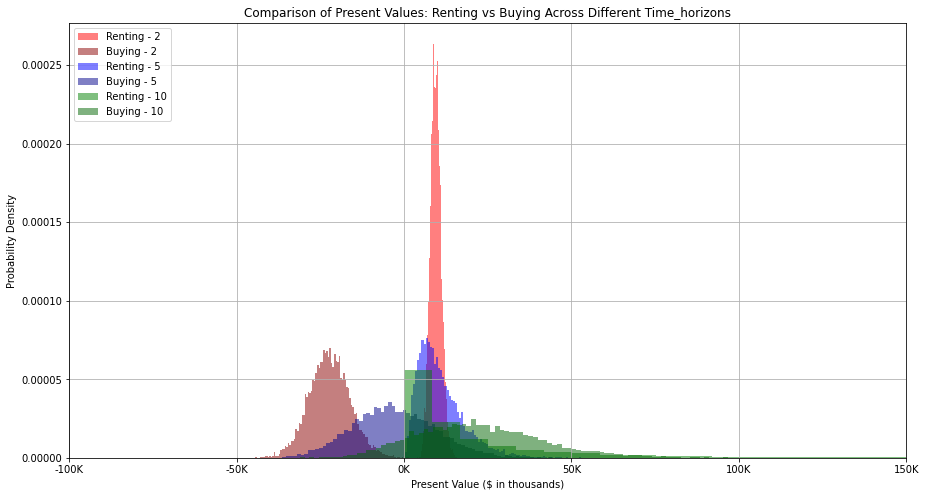

In [335]:
# Input parameters
buying_prices = [185000]
down_payment_percent = 0.00
mortgage_rates = [0.060]
appreciation_avg = 0.03
discount_rates = [0.10]
time_horizons = [2,5,10]  # in years
monthly_rent = 1200  # Rent as a tenant
monthly_rent_outs = [1500]  # Rent received when renting out the house
rent_out_after_n_years = 2 #Years after which to begin renting out
inflation_avg = 0.02
investment_avg = 0.10
property_tax_rate=0.015 #Property tax rate in TX
insurance_rate=0.001
plotPVdiagrams('time_horizon', time_horizons, keepRent=True)


<ipython-input-332-48f751e3ea5a>:150: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.0f}K'.format(tick/1000) for tick in ticks_loc])


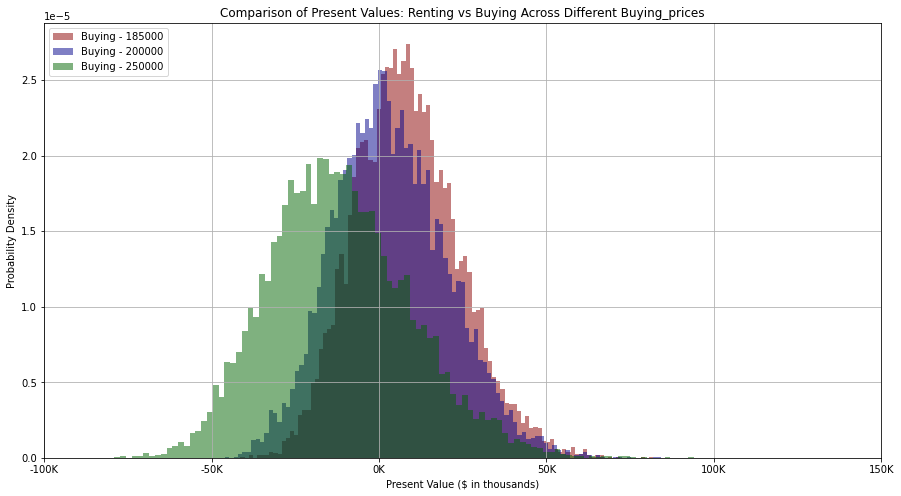

In [346]:
# Input parameters
buying_prices = [185000,200000,250000]
mortgage_rates = [0.060]
discount_rates = [0.10]
time_horizons = [7]  # in years
monthly_rent = 1200  # Rent as a tenant
monthly_rent_outs = [1500]  # Rent received when renting out the house
rent_out_after_n_years = 2 #Years after which to begin renting out
plotPVdiagrams('buying_price', buying_prices, keepRent=False)

<ipython-input-332-48f751e3ea5a>:150: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.0f}K'.format(tick/1000) for tick in ticks_loc])


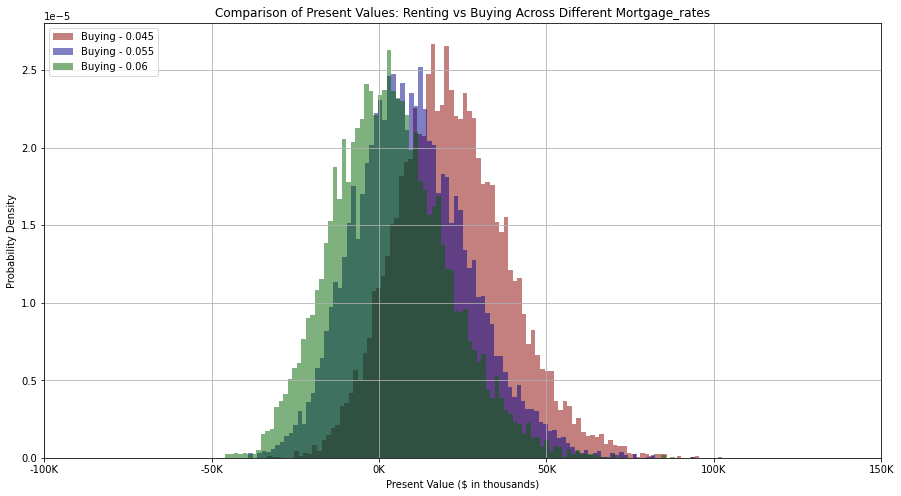

In [340]:
# Input parameters
buying_prices = [200000]
mortgage_rates = [0.045,0.055,0.060]
discount_rates = [0.10]
time_horizons = [7]  # in years
monthly_rent = 1200  # Rent as a tenant
monthly_rent_outs = [1500]  # Rent received when renting out the house

plotPVdiagrams('mortgage_rate', mortgage_rates, keepRent=False)

<ipython-input-332-48f751e3ea5a>:150: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.0f}K'.format(tick/1000) for tick in ticks_loc])


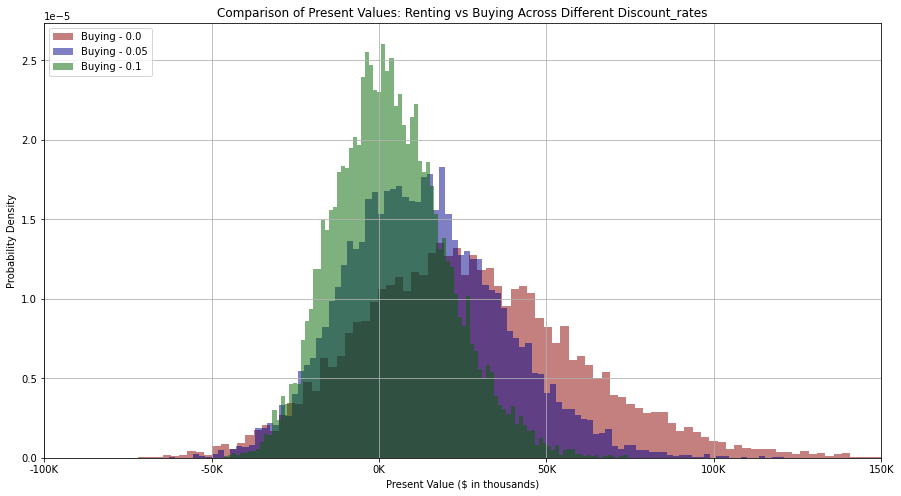

In [341]:
# Input parameters
buying_prices = [200000]
mortgage_rates = [0.060]
discount_rates = [0.0,0.05,0.10]
time_horizons = [7]  # in years
monthly_rent = 1200  # Rent as a tenant
monthly_rent_outs = [1500]  # Rent received when renting out the house

plotPVdiagrams('discount_rate', discount_rates, keepRent=False)

<ipython-input-332-48f751e3ea5a>:150: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.0f}K'.format(tick/1000) for tick in ticks_loc])


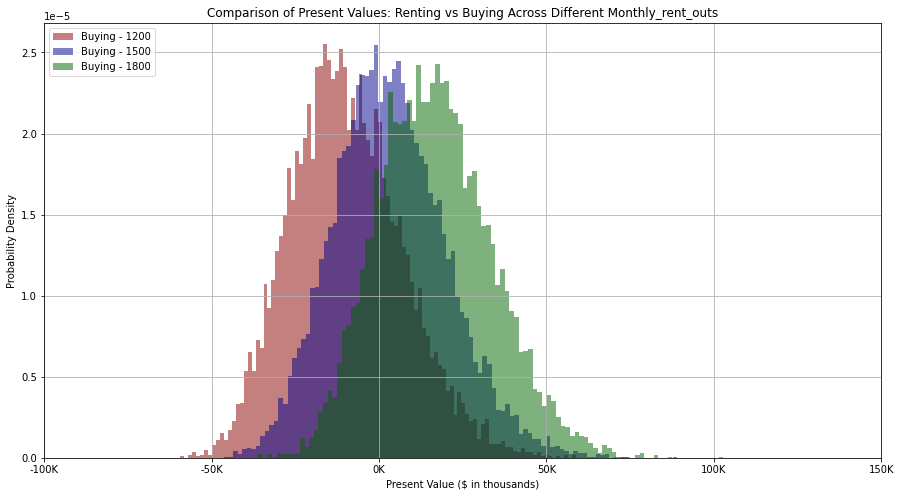

In [343]:
# Input parameters
buying_prices = [200000]
mortgage_rates = [0.060]
discount_rates = [0.10]
time_horizons = [7]  # in years
monthly_rent = 1200  # Rent as a tenant
monthly_rent_outs = [1200,1500,1800]  # Rent received when renting out the house

plotPVdiagrams('monthly_rent_out', monthly_rent_outs, keepRent=False)

In [265]:
# Input parameters
buying_price = 200000
down_payment_percent = 0.00
mortgage_rate = 0.065
appreciation_avg = 0.03
discount_rate = 0.11
time_horizon = 2  # in years
monthly_rent = 1200  # Rent as a tenant
monthly_rent_out = 1800  # Rent received when renting out the house
rent_out_after_n_years = 3 #Years after which to begin renting out
inflation_avg = 0.02
investment_avg = 0.10
property_tax_rate=0.015 #Property tax rate in TX
insurance_rate=0.001
# plotPVdiagrams(keepRent=False)
inflation_rate = np.random.normal(inflation_avg, 0.01)  # 2% mean, 1% std dev
appreciation_rate = np.random.normal(appreciation_avg, 0.02)  # 3% mean, 2% std dev
investment_rate= np.random.normal(investment_avg, 0.18)  # 10% mean, 18% std dev
compare_renting_vs_buying(buying_price, down_payment_percent, mortgage_rate, appreciation_rate, 
                              discount_rate, time_horizon, monthly_rent, monthly_rent_out, inflation_rate, 
                              investment_rate, property_tax_rate, insurance_rate, rent_out_after_n_years, 
                              yearly_maintenance_cost=0.02, commission=0.03)

Monthly payment: 1264.1360469859305
Month:1
Monthly Principal:180.80271365259728
total_monthly_homeownership_cost:1866.0117276719216
total_pv_cost_of_buying:1670.616854361695
Month:2
Monthly Principal:181.78206168488214
total_monthly_homeownership_cost:1867.8932719879717
total_pv_cost_of_buying:3327.6545417745674
Month:3
Monthly Principal:182.76671451900847
total_monthly_homeownership_cost:1869.7806982645784
total_pv_cost_of_buying:4971.22352863587
Month:4
Monthly Principal:183.75670088931975
total_monthly_homeownership_cost:1871.67402488954
total_pv_cost_of_buying:6601.433371566125
Month:5
Monthly Principal:184.75204968580374
total_monthly_homeownership_cost:1873.5732703081394
total_pv_cost_of_buying:8218.392725003296
Month:6
Monthly Principal:185.752789954935
total_monthly_homeownership_cost:1875.478453023322
total_pv_cost_of_buying:9822.20934873285
Month:7
Monthly Principal:186.7589509005245
total_monthly_homeownership_cost:1877.3895915958744
total_pv_cost_of_buying:11412.9901153542

(15464.184347542474, -23649.357403449976)

In [53]:
import pandas as pd

In [108]:
# Example of Min-Max Scaling to a 1-5 scale
def min_max_scaling(series, scale_min=1, scale_max=5, is_higher_better=True):
    min_val = series.min()
    max_val = series.max()
    scale_range = scale_max - scale_min
    normalized_series = (series - min_val) / (max_val - min_val)
    
    if not is_higher_better:
        normalized_series = 1 - normalized_series  # Invert the scale for cost-like attributes
    
    scaled_series = normalized_series * scale_range + scale_min
    return scaled_series
def compute_weighted_score(row, weights):
    weighted_score = row * weights
    return weighted_score.sum()

In [116]:
DecisionM=pd.read_excel('Decision_Matrix_Houses.xlsx',engine='openpyxl')
DecisionM.set_index(DecisionM.columns[0], inplace=True)
DecisionM2=DecisionM.copy()
DecisionM2=DecisionM2.drop(['HOA (Y/N)','Other notes','Rental Market Audience (Write in)'], axis=1)
weights = DecisionM.iloc[-1]
DecisionM2 = DecisionM2.drop(DecisionM2.index[-1])


# Standardize Rental Income (Higher is better)
DecisionM2['Rental Income of area and similar houses ($)'] = min_max_scaling(DecisionM2['Rental Income of area and similar houses ($)'], is_higher_better=True)

# Standardize Cost of the House (Lower is better)
DecisionM2['Cost of the House ($)'] = min_max_scaling(DecisionM2['Cost of the House ($)'], is_higher_better=False)

# Standardize Potential Future Monthly Profit (Higher is better)
DecisionM2['Potential Future Monthly Profit ($)'] = min_max_scaling(DecisionM2['Potential Future Monthly Profit ($)'], is_higher_better=True)

DecisionM2['Drive to Sheppard (Min)']=min_max_scaling(DecisionM2['Drive to Sheppard (Min)'],is_higher_better=False)

DecisionM2['Sqft of the house']=min_max_scaling(DecisionM2['Sqft of the house'],is_higher_better=True)

DecisionM2['Cap Rate (yearly profit/market value) (%)']=min_max_scaling(DecisionM2['Cap Rate (yearly profit/market value) (%)'],is_higher_better=True)

DecisionM2['Cost of Upgrades to Live in and for Renting ($)']=min_max_scaling(DecisionM2['Cost of Upgrades to Live in and for Renting ($)'],is_higher_better=False)

# Compute the overall score for each house
DecisionM2['Overall Score'] = DecisionM2.apply(compute_weighted_score, axis=1, weights=weights)

DecisionM2

,Location (Rating),Drive to Sheppard (Min),"Layout and Design (how many beds, baths/modifiable, desirable layout, 5= great layout and easy to upgrade) (Rating)",Sqft of the house,"Condition of the House (age of roof, windows, HVAC, plumbing and electrical) (Rating)","Lifestyle Needs (Noise, walkability, yard, room for hobbies) (Rating)",Cost of the House ($),Rental Income of area and similar houses ($),Renter's Maintenance (How much yearly maintenance regardless of renter type) (Rating),Cost of Upgrades to Live in and for Renting ($),Cap Rate (yearly profit/market value) (%),Potential Future Monthly Profit ($),Overall Like (Rating),Overall Score
House,,,,,,,,,,,,,,
2108 Selma,4.0,5.000000,3.0,1.757895,3.0,3.0,3.533333,2.6,4.0,4.684211,3.332431,3.477971,2,151.247697
2119 Selma,4.0,5.000000,2.0,1.000000,5.0,3.0,5.000000,1.8,3.0,4.684211,4.068424,4.738318,1,154.396857
5603 Greentree,4.0,4.764706,4.0,2.452632,2.0,4.0,3.666667,2.6,3.0,4.157895,3.476566,3.670227,2,152.629551
2308 Randolph,4.0,4.764706,4.0,1.810526,3.0,4.0,4.166667,2.6,3.0,4.684211,4.068424,4.391188,4,179.328599
1305 Grant Street,4.0,2.882353,2.0,3.673684,2.0,3.0,3.333333,1.8,2.0,3.105263,2.183248,2.335113,2,116.204706
4203 Kingsbury Drive,3.0,2.176471,4.0,2.465789,3.0,1.0,3.000000,1.0,1.0,1.000000,1.000000,1.000000,1,87.348142
4115 Seymour Road,3.0,2.411765,5.0,2.073684,4.0,4.0,3.833333,1.0,3.0,4.684211,1.644627,2.201602,4,147.964860
2819 Barrywood,4.0,2.176471,4.0,2.547368,2.0,4.0,3.266667,1.8,3.0,2.052632,2.125115,2.238985,2,120.513475
2502 Lansing Blvd,3.0,2.176471,2.0,3.386842,2.7,3.0,3.333333,2.2,3.0,2.052632,2.654542,2.762350,2,116.061958


In [113]:
weights

Location (Rating)                                                                                                      3.0
Drive to Sheppard (Min)                                                                                                5.0
Layout and Design (how many beds, baths/modifiable, desirable layout, 5= great layout and easy to upgrade) (Rating)    4.0
Sqft of the house                                                                                                      1.0
Condition of the House (age of roof, windows, HVAC, plumbing and electrical) (Rating)                                  3.0
Lifestyle Needs (Noise, walkability, yard, room for hobbies) (Rating)                                                  2.0
Cost of the House ($)                                                                                                  5.0
Rental Income of area and similar houses ($)                                                                           4.0
Renter's Mainten

In [117]:
DecisionM2.sort_values('Overall Score', ascending=False)

,Location (Rating),Drive to Sheppard (Min),"Layout and Design (how many beds, baths/modifiable, desirable layout, 5= great layout and easy to upgrade) (Rating)",Sqft of the house,"Condition of the House (age of roof, windows, HVAC, plumbing and electrical) (Rating)","Lifestyle Needs (Noise, walkability, yard, room for hobbies) (Rating)",Cost of the House ($),Rental Income of area and similar houses ($),Renter's Maintenance (How much yearly maintenance regardless of renter type) (Rating),Cost of Upgrades to Live in and for Renting ($),Cap Rate (yearly profit/market value) (%),Potential Future Monthly Profit ($),Overall Like (Rating),Overall Score
House,,,,,,,,,,,,,,
2308 Randolph,4.0,4.764706,4.0,1.810526,3.0,4.0,4.166667,2.6,3.0,4.684211,4.068424,4.391188,4,179.328599
2703 Shepherds Glen,4.5,1.470588,4.3,3.063158,5.0,4.3,2.500000,4.2,4.0,4.684211,4.068424,3.696929,4,170.006014
3310 Glenwood Ave,5.0,2.176471,5.0,5.000000,4.3,4.3,1.000000,5.0,4.0,4.157895,3.493286,2.388518,4,164.627304
4907 Reginald Dr,3.0,1.235294,5.0,2.321053,5.0,4.0,2.666667,3.4,3.0,4.684211,3.375910,3.082777,4,156.964984
2119 Selma,4.0,5.000000,2.0,1.000000,5.0,3.0,5.000000,1.8,3.0,4.684211,4.068424,4.738318,1,154.396857
5603 Greentree,4.0,4.764706,4.0,2.452632,2.0,4.0,3.666667,2.6,3.0,4.157895,3.476566,3.670227,2,152.629551
4213 Seabury Dr,4.0,2.176471,5.0,2.915789,3.7,4.5,2.833333,2.2,4.0,4.157895,2.212704,2.041389,4,151.812950
2108 Selma,4.0,5.000000,3.0,1.757895,3.0,3.0,3.533333,2.6,4.0,4.684211,3.332431,3.477971,2,151.247697
4703 Langford Lane,3.0,1.000000,2.5,4.565789,4.0,4.0,3.700000,3.8,2.7,5.000000,5.000000,5.000000,2,148.665789


In [344]:
len(DecisionM2)

20

In [115]:
pd.merge(DecisionM2, DecisionM, on='House', how='left')

,Location (Rating)_x,Drive to Sheppard (Min)_x,"Layout and Design (how many beds, baths/modifiable, desirable layout, 5= great layout and easy to upgrade) (Rating)_x",Sqft of the house_x,"Condition of the House (age of roof, windows, HVAC, plumbing and electrical) (Rating)_x","Lifestyle Needs (Noise, walkability, yard, room for hobbies) (Rating)_x",Cost of the House ($)_x,Rental Income of area and similar houses ($)_x,Renter's Maintenance (How much yearly maintenance regardless of renter type) (Rating)_x,Cost of Upgrades to Live in and for Renting ($)_x,...,Sqft of the house_y,"Condition of the House (age of roof, windows, HVAC, plumbing and electrical) (Rating)_y","Lifestyle Needs (Noise, walkability, yard, room for hobbies) (Rating)_y",Cost of the House ($)_y,Rental Income of area and similar houses ($)_y,Renter's Maintenance (How much yearly maintenance regardless of renter type) (Rating)_y,Cost of Upgrades to Live in and for Renting ($)_y,Cap Rate (yearly profit/market value) (%)_y,Potential Future Monthly Profit ($)_y,Overall Like (Rating)_y
House,,,,,,,,,,,,,,,,,,,,,
2108 Selma,4.0,5.000000,3.0,1.757895,3.0,3.0,3.533333,2.6,4.0,4.684211,...,1450,3.0,3.0,219,1600,4.0,5,0.055137,-863.75,2
2119 Selma,4.0,5.000000,2.0,1.000000,5.0,3.0,5.000000,1.8,3.0,4.684211,...,1162,5.0,3.0,175,1400,3.0,5,0.061800,-568.75,1
5603 Greentree,4.0,4.764706,4.0,2.452632,2.0,4.0,3.666667,2.6,3.0,4.157895,...,1714,2.0,4.0,215,1600,3.0,10,0.056442,-818.75,2
2308 Randolph,4.0,4.764706,4.0,1.810526,3.0,4.0,4.166667,2.6,3.0,4.684211,...,1470,3.0,4.0,200,1600,3.0,5,0.061800,-650.00,4
1305 Grant Street,4.0,2.882353,2.0,3.673684,2.0,3.0,3.333333,1.8,2.0,3.105263,...,2178,2.0,3.0,225,1400,2.0,20,0.044733,-1131.25,2
4203 Kingsbury Drive,3.0,2.176471,4.0,2.465789,3.0,1.0,3.000000,1.0,1.0,1.000000,...,1719,3.0,1.0,235,1200,1.0,40,0.034021,-1443.75,1
4115 Seymour Road,3.0,2.411765,5.0,2.073684,4.0,4.0,3.833333,1.0,3.0,4.684211,...,1570,4.0,4.0,210,1200,3.0,5,0.039857,-1162.50,4
2819 Barrywood,4.0,2.176471,4.0,2.547368,2.0,4.0,3.266667,1.8,3.0,2.052632,...,1750,2.0,4.0,227,1400,3.0,30,0.044207,-1153.75,2
2502 Lansing Blvd,3.0,2.176471,2.0,3.386842,2.7,3.0,3.333333,2.2,3.0,2.052632,...,2069,2.7,3.0,225,1500,3.0,30,0.049000,-1031.25,2


In [124]:
DecisionM2['Notes']=DecisionM['Other notes']
DecisionM2['Cost of the House ($K)']=DecisionM['Cost of the House ($)']
DecisionM2['Rental Income of area and similar houses ($/mo)']=DecisionM2['Rental Income of area and similar houses ($)']
DecisionM2

,Location (Rating),Drive to Sheppard (Min),"Layout and Design (how many beds, baths/modifiable, desirable layout, 5= great layout and easy to upgrade) (Rating)",Sqft of the house,"Condition of the House (age of roof, windows, HVAC, plumbing and electrical) (Rating)","Lifestyle Needs (Noise, walkability, yard, room for hobbies) (Rating)",Cost of the House ($),Rental Income of area and similar houses ($),Renter's Maintenance (How much yearly maintenance regardless of renter type) (Rating),Cost of Upgrades to Live in and for Renting ($),Cap Rate (yearly profit/market value) (%),Potential Future Monthly Profit ($),Overall Like (Rating),Overall Score,Notes,Cost of the House ($K),Rental Income of area and similar houses ($/mo)
House,,,,,,,,,,,,,,,,,
2108 Selma,4.0,5.000000,3.0,1.757895,3.0,3.0,3.533333,2.6,4.0,4.684211,3.332431,3.477971,2,151.247697,"Right near sheppard, metal roof, interesting l...",219,2.6
2119 Selma,4.0,5.000000,2.0,1.000000,5.0,3.0,5.000000,1.8,3.0,4.684211,4.068424,4.738318,1,154.396857,Close to sheppard,175,1.8
5603 Greentree,4.0,4.764706,4.0,2.452632,2.0,4.0,3.666667,2.6,3.0,4.157895,3.476566,3.670227,2,152.629551,NaN,215,2.6
2308 Randolph,4.0,4.764706,4.0,1.810526,3.0,4.0,4.166667,2.6,3.0,4.684211,4.068424,4.391188,4,179.328599,NaN,200,2.6
1305 Grant Street,4.0,2.882353,2.0,3.673684,2.0,3.0,3.333333,1.8,2.0,3.105263,2.183248,2.335113,2,116.204706,"Very old house, will need a lot of upkeep and ...",225,1.8
4203 Kingsbury Drive,3.0,2.176471,4.0,2.465789,3.0,1.0,3.000000,1.0,1.0,1.000000,1.000000,1.000000,1,87.348142,"Has pool, also near apartment complex",235,1.0
4115 Seymour Road,3.0,2.411765,5.0,2.073684,4.0,4.0,3.833333,1.0,3.0,4.684211,1.644627,2.201602,4,147.964860,"Nice backyard patio area, some cracking of the...",210,1.0
2819 Barrywood,4.0,2.176471,4.0,2.547368,2.0,4.0,3.266667,1.8,3.0,2.052632,2.125115,2.238985,2,120.513475,"Smoker's house, good layout, needs new AC unit.",227,1.8
2502 Lansing Blvd,3.0,2.176471,2.0,3.386842,2.7,3.0,3.333333,2.2,3.0,2.052632,2.654542,2.762350,2,116.061958,"Just an oddly oriented house with a super, sup...",225,2.2


In [125]:
DecisionM2.to_excel('Decision_Matrix_Modified_With_Net_Scores.xlsx')